# Лабораторная Работа "Жесткие системы ОДУ"

In [1]:
from solvers import CALC_TYPE, RungeKuttaCollection
import matplotlib.pyplot as plt
import numpy as np


> **ДИСКЛЕЙМЕР:** Реализации методов лежат в файле ```solvers.py```

## Задача

Вариант 14, задача X.9.14: Экогенетическая модель №2.

$$\begin{cases} 
\dot{x} = x(2 \alpha_1 - 0.5x - \alpha_1^2 \alpha_2^{-2}y) \\
\dot{y} = y(2 \alpha_2 - 0.5y - \alpha_2^2 \alpha_1^{-2}x) \\
\dot{\alpha_1} = 2\varepsilon(1 - \alpha_1 \alpha_2^{-2}y) \\
\dot{\alpha_2} = 2\varepsilon(1 - \alpha_2 \alpha_1^{-2}x) \\
\end{cases}$$

Со следующими параметрами и начальными условиями:

$$\begin{cases}
\varepsilon \le 0.01 \\
0 \le x_0 \le 40 \\
0 \le y_0 \le 40 \\
\alpha_{10} << 1 \\
\alpha_{20} = 10 \\
0 \le t \le 2000
\end{cases}$$

In [2]:
DEFAULT_START = np.array([20, 20, 0.1, 10], dtype=CALC_TYPE)
DEFAULT_BOUNDS = (0, 2000)

# Y = [x, y, a1, a2]
# start = Y0
def task(eps, h, solvers, labels, title, start=DEFAULT_START, tbounds=DEFAULT_BOUNDS):
    tmin, tmax = tbounds
    t0 = 0

    def func(Y, t):
        x, y, a1, a2 = Y
        f = np.empty_like(Y)

        f[0] = x * (2 * a1 - 0.5*x - y*(a1/a2)**2)
        f[1] = y * (2 * a2 - 0.5*y - x*(a2/a1)**2)
        f[2] = 2 * eps * (1 - y*a1 / (a2**2))
        f[3] = 2 * eps * (1 - x*a2 / (a1**2))

        return f

    for solver in solvers:
        solver.init_problem(func, t0, start)

    fig, ((xplot, a1plot), (yplot, a2plot)) = plt.subplots(2, 2)
    fig.set_size_inches(14, 10)

    def init_subplot(ax, name, startval):
        ax.set_xlabel("$t$")
        ax.set_ylabel(f"${name}$")
        ax.set_title(f"${name} (t)$")
        ax.grid()
        ax.set_xlim([tmin, tmax])
        ax.scatter([t0], [startval], 64, marker="o", color="k", zorder=16)

    init_subplot(xplot, "x", start[0])
    init_subplot(yplot, "y", start[1])
    init_subplot(a1plot, "\\alpha_1", start[2])
    init_subplot(a2plot, "\\alpha_2", start[3])

    def plot(T, X, Y, A1, A2, label, *args):
        xplot.plot(T, X, *args, label=label)
        yplot.plot(T, Y, *args)
        a1plot.plot(T, A1, *args)
        a2plot.plot(T, A2, *args)

    for i, (solver, label) in enumerate(zip(solvers, labels)):
        nsteps = np.ceil((tmax - t0) / solver.get_h()).astype(np.uint64)
        
        T = []
        X = []
        Y = []
        A1 = []
        A2 = []

        for _ in range(nsteps):
            t, (x, y, a1, a2) = solver.step()
            T.append(t)
            X.append(x)
            Y.append(y)
            A1.append(a1)
            A2.append(a2)

        if i + 1 == len(solvers):
            plot(T, X, Y, A1, A2, label, "k--")
        else:
            plot(T, X, Y, A1, A2, label)

        
    fig.legend()
    plt.suptitle(f"$Ecogenetic, \\varepsilon={eps}$\n${title}, h={h}$")
    plt.show()

### Валидация

Проверять работоспособность методов будем на более простой задаче той же размерности:

$$\begin{cases}
\ddot{x} + x = 0.2 cos(t) \\
\ddot{y} + y = 0.2 cos(t) \\
x_0 = 1,~ \dot{x}_0 = 0 \\
y_0 = 0,~ \dot{y}_0 = 1 \\
\end{cases}$$

Имеющую аналитическое решение

$$\begin{cases}
x(t) = cos(t) + 0.1tsin(t) \\
y(t) = sin(t) + 0.1tsin(t)
\end{cases}$$

In [3]:
def validate(solvers, labels, steps, bound, title):
    # Y = x, y, x', y'
    def test_f(Y, t):
        x, y, xd, yd = Y

        f = np.empty_like(Y, dtype=CALC_TYPE)

        val = 0.2 * np.cos(t)

        f[0] = xd # x' = xd 
        f[1] = yd # y' = yd
        f[2] = - x + val # (xd)' = -x + 0.2cost
        f[3] = - y + val # (yd)' = -y + 0.2cost

        return f

    x0 = 1; xd0 = 0
    y0 = 0; yd0 = 1

    for solver in solvers:
        solver.init_problem(test_f, 0, np.array([x0, y0, xd0, yd0]))

    T_real = np.linspace(0, bound, 1000)
    X_real = 0.1*T_real * np.sin(T_real) + np.cos(T_real)
    Y_real = 0.1*T_real * np.sin(T_real) + np.sin(T_real)

    fig, (xplot, yplot) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)

    xplot.set_xlabel("$t$")
    xplot.set_ylabel("$x$")
    xplot.grid()

    yplot.set_xlabel("$t$")
    yplot.set_ylabel("$y$")
    yplot.grid()

    xplot.plot(T_real, X_real, "k--", label="$Analytical$")
    yplot.plot(T_real, Y_real, "k--")

    for solver, label in zip(solvers, labels):
        T = []
        X = []
        Y = []
        for _ in range(steps):
            t, (x, y, _, __) = solver.step()
            T.append(t)
            X.append(x)
            Y.append(y)
        
        xplot.plot(T, X, label=label)
        yplot.plot(T, Y)
    
    plt.suptitle(f"$Method~ validation: ~{title}$")
    fig.legend()
    plt.show()

### Сценарии

In [4]:
class Scenario:
    def __init__(self, name, eps, scond, time):
        self.name = name
        self.eps = eps        
        self.time = time

        # x0, y0, a10, a20
        self.scond = np.array(scond, dtype=CALC_TYPE)

    def run(self, h, solvers, labels):
        task(self.eps, h, solvers, labels, self.name, self.scond, self.time)    

Case1 = Scenario("Случай ~x_0=40, ~y_0=1", 0.01, [40, 1, 0.1, 10], (-0.001, 0.1))
Case2 = Scenario("Случай ~x_0=1, ~y_0=40", 0.01, [1, 40, 0.1, 10], (-0.001, 0.1)) 
Case3 = Scenario("Случай ~x_0=y_0=20", 0.01, [20, 20, 10, 10], (-.1, 10))
Case4 = Scenario("Прикольная~ штука", 1, [1, 10, 7, 10], (-0.001, 2))

## 0. Попробуем явный метод

Применим явный метод Рунге-Кутты к этой задаче.

Устойчивой картины решения удалось добиться при

$$\begin{cases}
\varepsilon = 0.01 \\
x_0 = y_0 = 1 \\
a_{20} = 10 \\

a_{10} = 0.2
\end{cases}$$

По условию $a_{10} << 1$. При меньших $a_{10}$ решение становилось нестабильным.

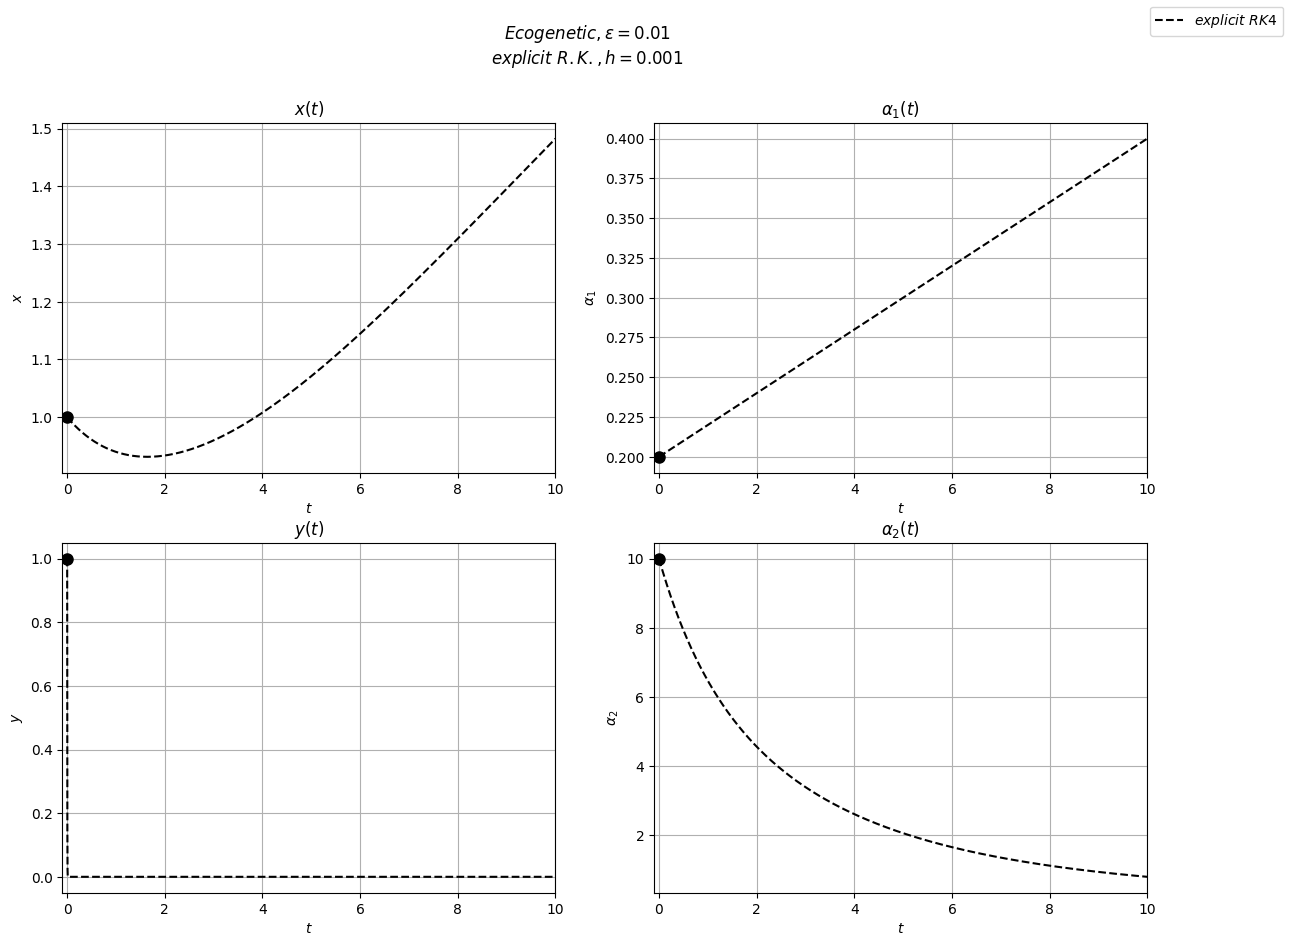

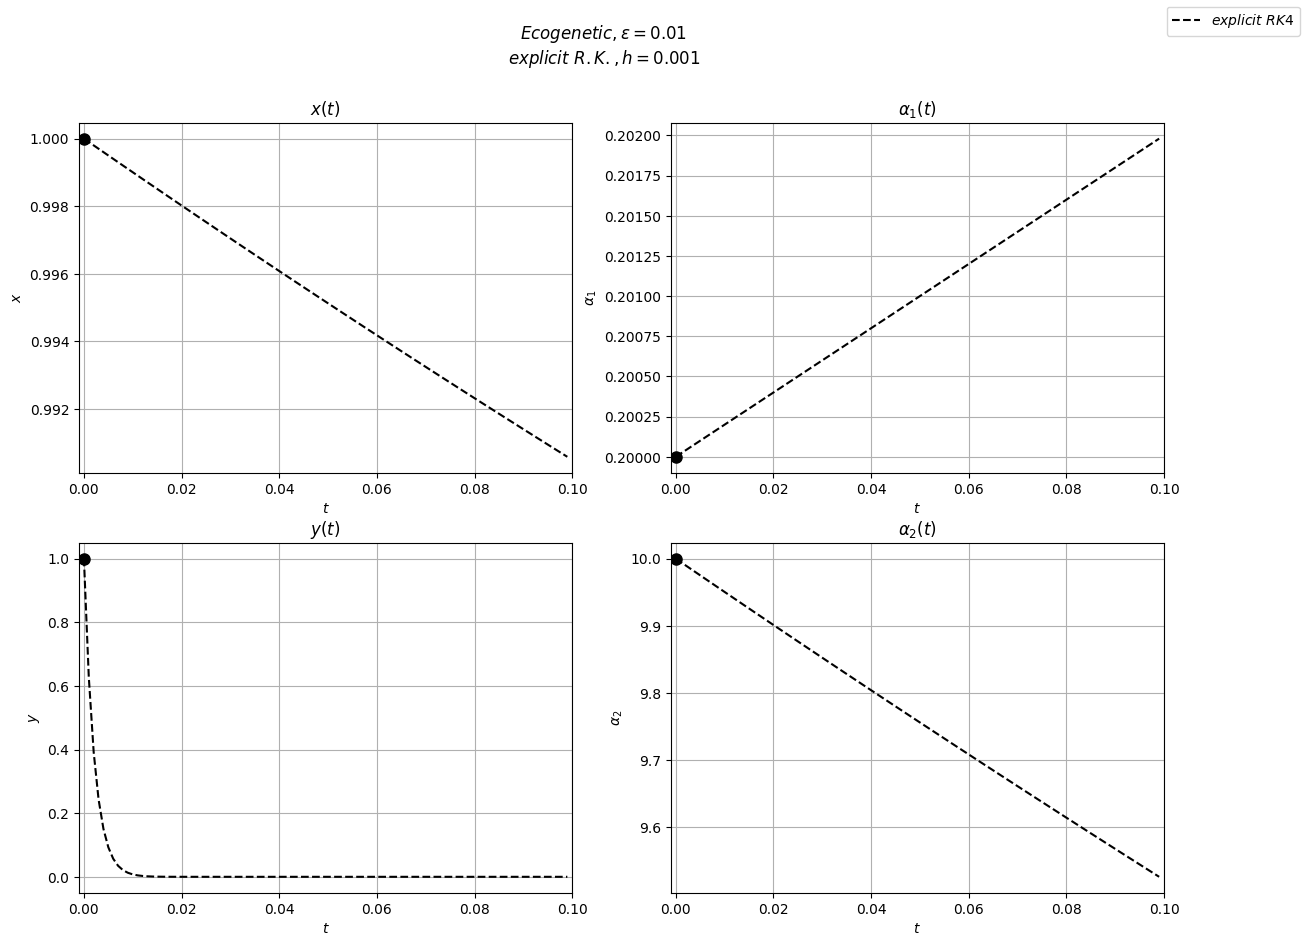

In [5]:
def solution_rk_explicit(e, h, time):
    solvers = [RungeKuttaCollection.create_e4(h)]

    labels = ["$explicit~ RK4$"]

    x0 = 1
    y0 = 1
    a10 = 0.2
    a20 = 10

    start = np.array([x0, y0, a10, a20])

    task(e, h, solvers, labels, "explicit~ R.K.", start, time)

solution_rk_explicit(0.01, 1e-3, (-.1, 10))
solution_rk_explicit(0.01, 1e-3, (-.001, 0.1))

> Из картины x(t) на обоих графиках видно, что задача является жесткой

## 1. Неявный Метод Рунге-Кутты

### Валидация

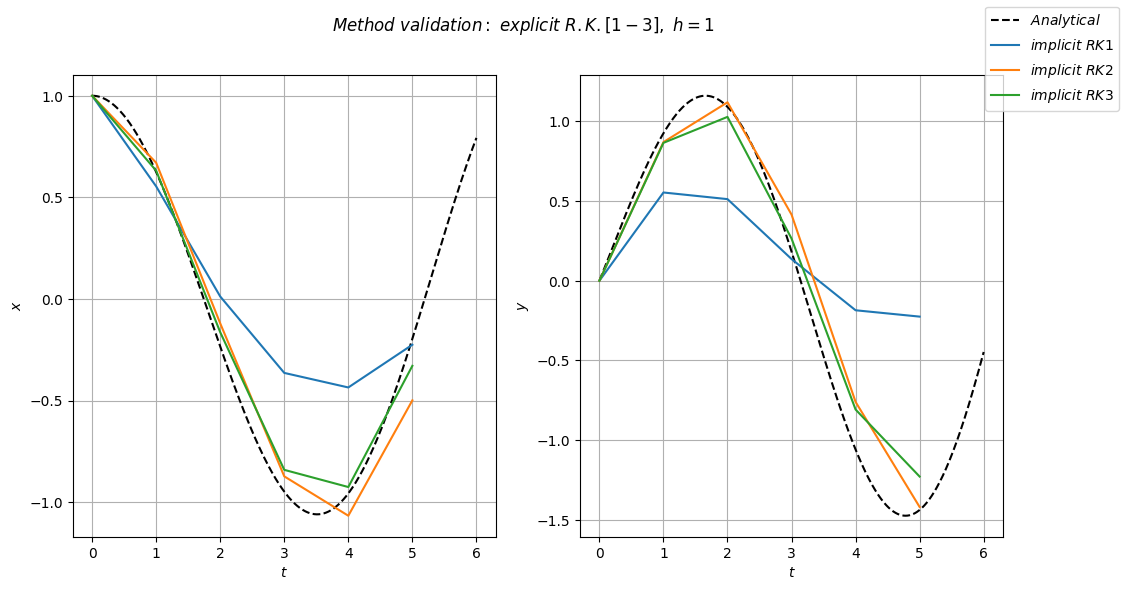

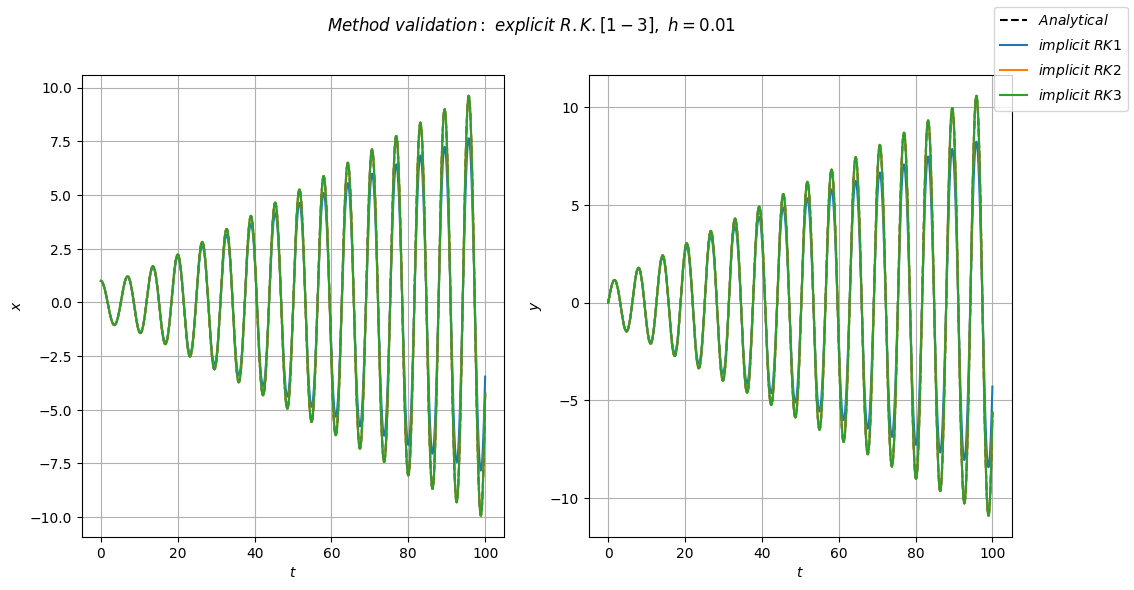

In [6]:
def validate_rk(steps, h):
    solvers = [RungeKuttaCollection.create_i1(h),
               RungeKuttaCollection.create_i2(h),
               RungeKuttaCollection.create_i3(h)]

    labels = ["$implicit~ RK1$", "$implicit~ RK2$", "$implicit~ RK3$"]

    validate(solvers, labels, steps, steps*h, f"explicit~ R.K. [1-3],~h={h}")
 
validate_rk(6, 1)
validate_rk(10000, 1e-2)

### Решение

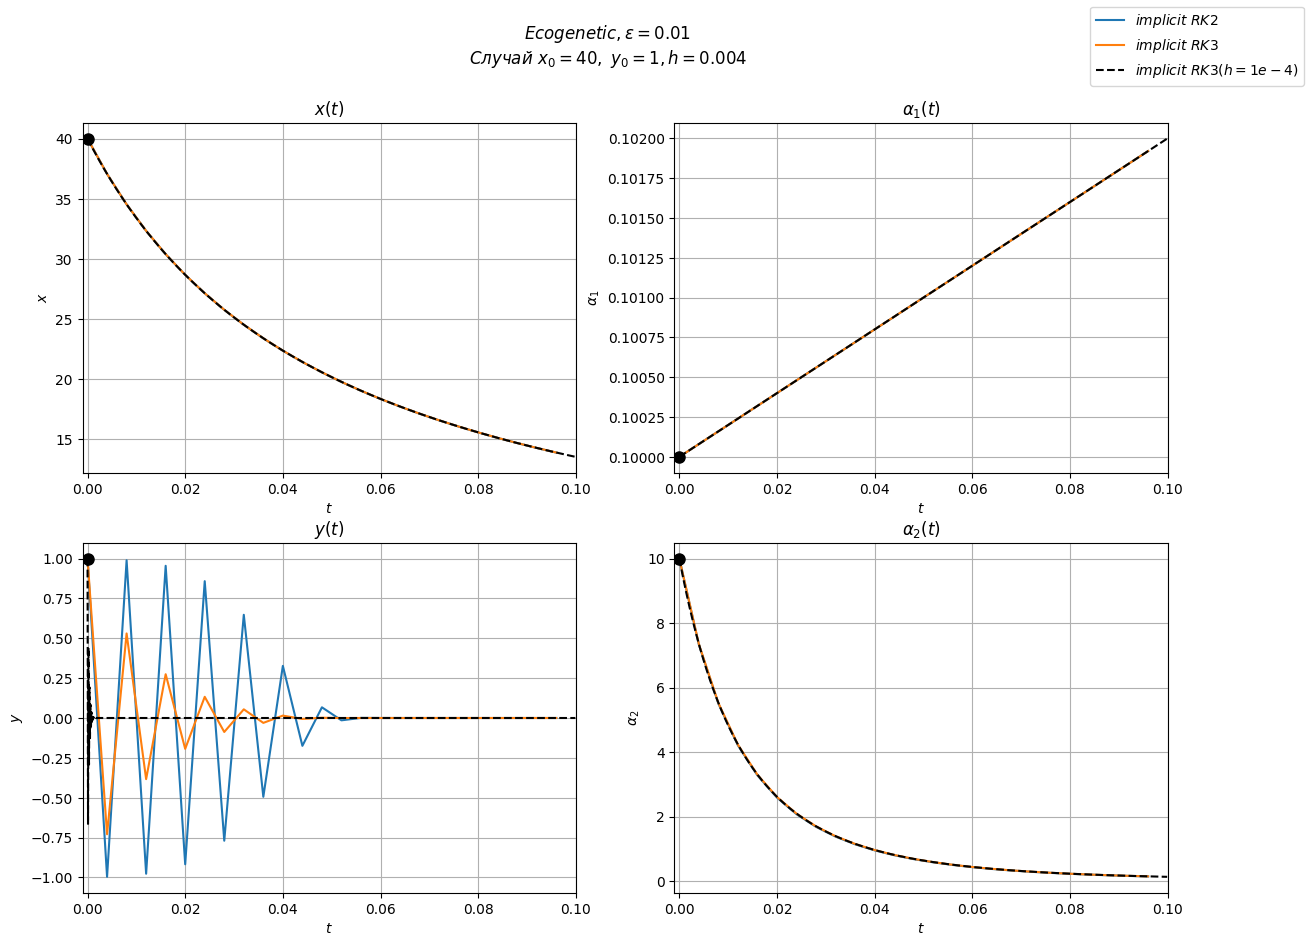

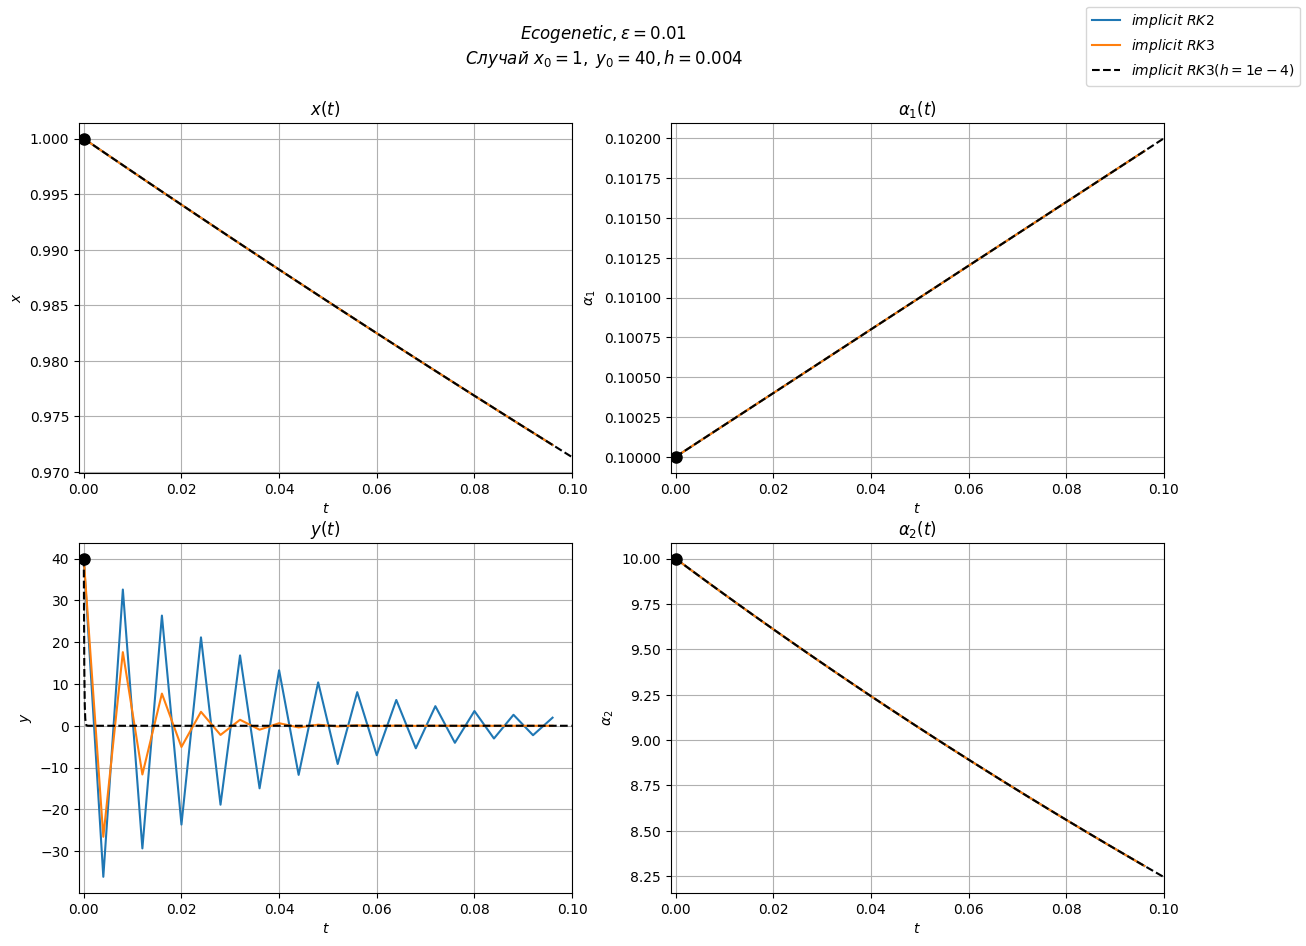

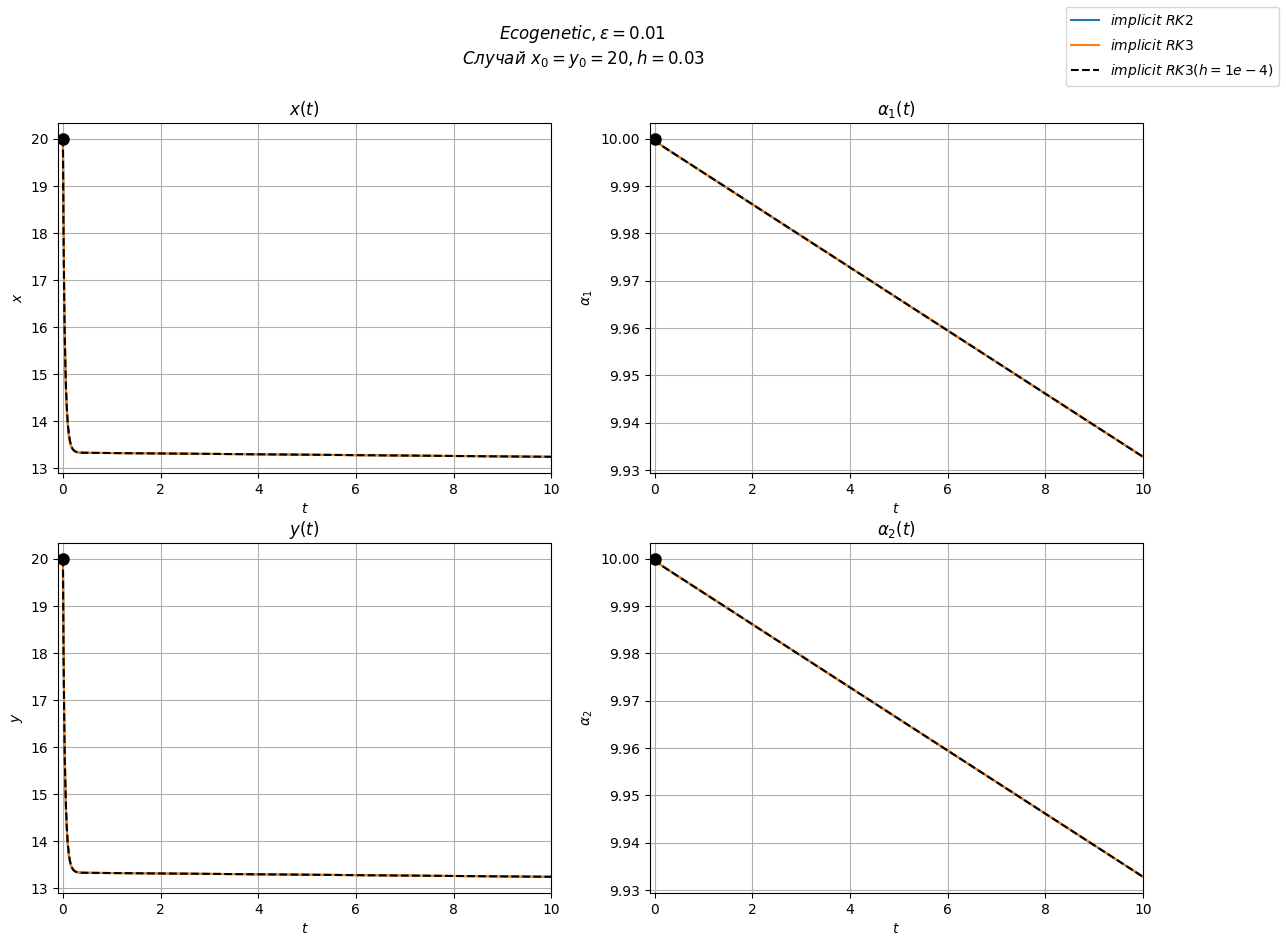

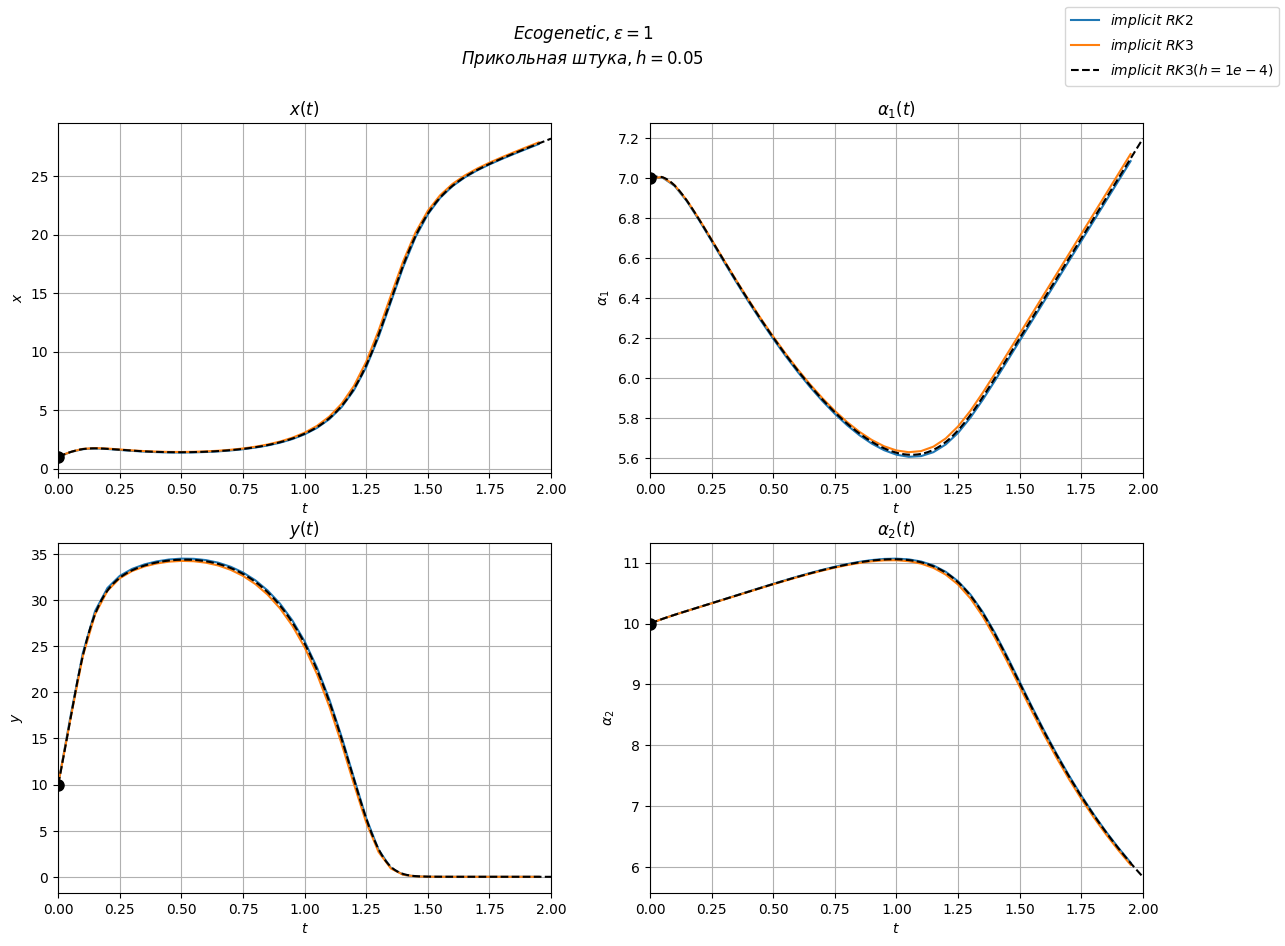

In [7]:
def solution_rk(h, scenario):
    solvers = [RungeKuttaCollection.create_i2(h),
               RungeKuttaCollection.create_i3(h),
               RungeKuttaCollection.create_i3(1e-4)]

    labels = ["$implicit~ RK2$", "$implicit~ RK3$", "$implicit~ RK3 (h=1e-4)$"]

    scenario.run(h, solvers, labels)

solution_rk(4e-3, Case1)
solution_rk(4e-3, Case2)
solution_rk(3e-2, Case3)
solution_rk(5e-2, Case4)